# Kitaev's Toric Code

Kitaev's Toric code was one of the first examples of a topological quantum error correction code.

The toric code arranges physical qubits on a 2D square lattice on the surface of a torus. The code works by defining two types of local stabilizer operators:

Star Operators: For each vertex $v$ (or star) on the lattice, this operator is the product of Pauli-X operators on the four qubits connected to it: $A_v = \prod_{i\in v}\sigma_i^x$.

Plaquette Operators: For each plaquette $p$ of the lattice, this operator is the product of Pauli-Z operators on the four qubits that form its border: $B_p = \prod_{i\in p}\sigma_i^z$.

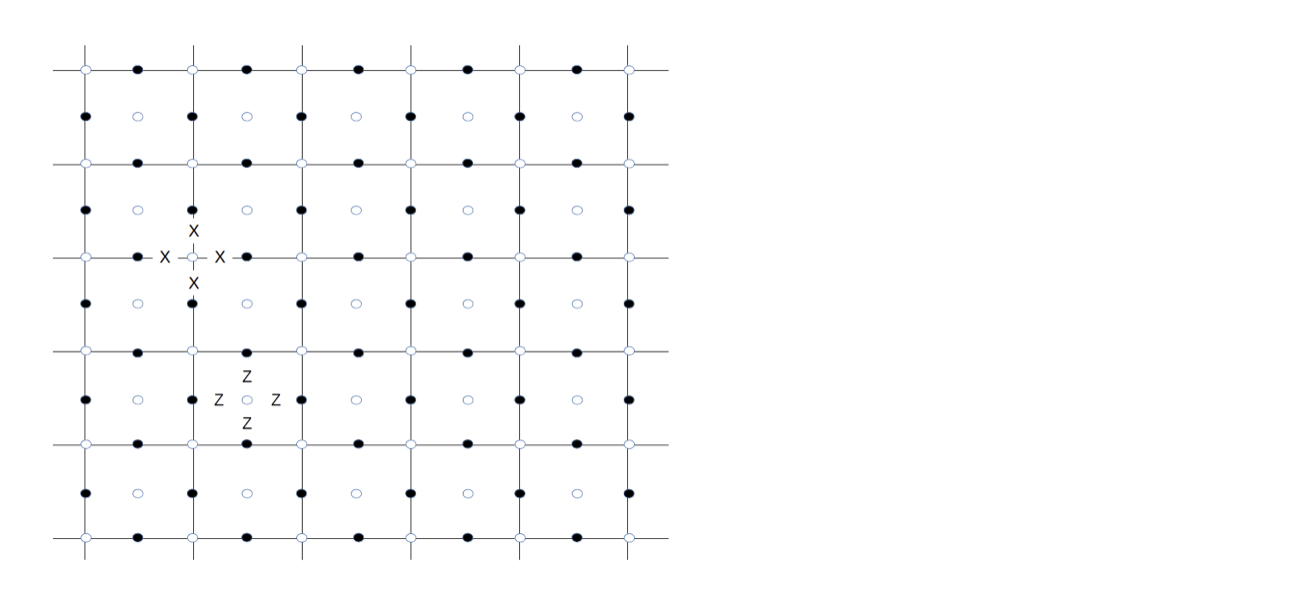

Here the black circles are data qubits and the empty circles are ancilla qubits or syndrome qubits that leep track of the stabilizers.

The codespace is the +1 eigenspace spanned by all star and plaquette operators. When a local error occurs (e.g., a bit-flip or phase-flip on a single qubit), it violates the stabilizer conditions at the adjacent vertices or plaquettes, creating a pair of "excitations" or anyons. The errors, or plaquette violations are of two kinds, 'e' and 'm' 9figure below). The process of error correction involves detecting these excitations and applying a correction string to annihilate them in pairs.

The logical information is encoded in non-local, "topological" loops that wrap around the torus. Since any local error only creates a small, local chain of excitations, it cannot change the global, topological state of these loops. This topological protection is the key to the toric code's robustness. The logical operators are marked by the solid and dashed non-contractible lines in the figure below.


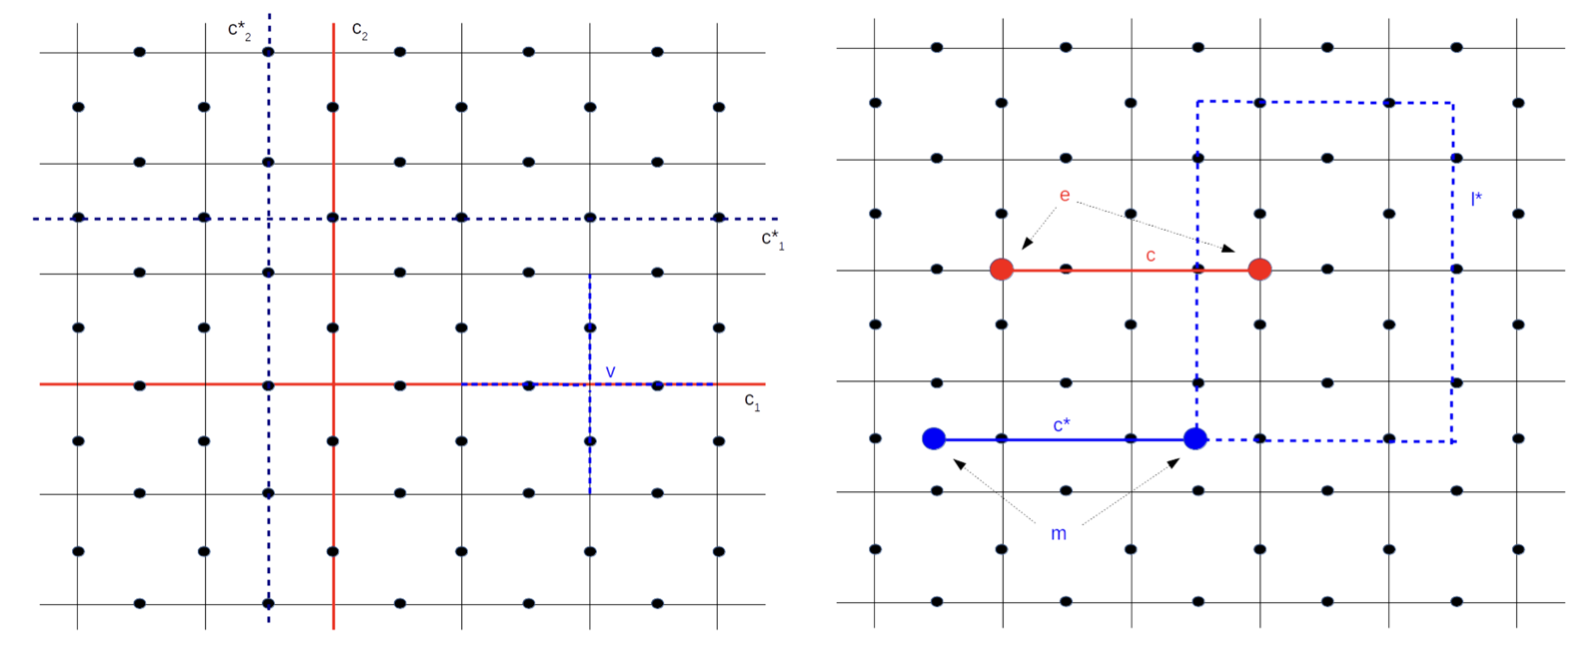



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
from pymatching import Matching
import time

# Repetition code as a building block for toric code stabilizers

We employ a construction of the stabilizers by taking the hypergraph product of two repetition codes. As discussed in arxiv.org/pdf/0903.0566.

1. def build_repetition_code(n): Defines a function that takes an integer n (the length of the code) as input and constructs the parity-check matrix for a length-n repetition code.
2. def toric_code_X(Z)_checks(L) generates X(Z)-type stabilizer check matrix for toric code of size L. Each (i,j) element of this $H_X(Z)$ matrix will be 1 if the ith stabiliser acts non-trivially on the jth qubit, and is 0 otherwise.
3. def toric_code_logicals(L) returns the logical X and Z operators. These represent operations on the encoded logical qubits. They are non-trivial loops around the torus. They commute with the stabilizers.


In [29]:
def build_repetition_code(n):
    
    # For each check 'i', it involves qubit 'i' and qubit '(i + 1) % n'.
    # This creates the connections for a circular code.
    rows, cols = zip(*((i, j) for i in range(n) for j in (i, (i + 1) % n)))
    values = np.ones(2 * n, dtype=np.uint8)
    # This matrix describes checks where each check s_i = Z_i Z_{i+1}.
    return csc_matrix((values, (rows, cols)), shape=(n, n))


def toric_code_X_checks(L):
   
    # 1. Create the base check matrix for a repetition code of length L.
    base = build_repetition_code(L)
    
    # 2. Create an L x L identity matrix.
    identity_L = eye(L)

    # 3. The toric code's check matrix is built from two parts.
    # Part 1: kron(base, identity_L) defines the connections *along the rows*.
    # It applies the repetition code checks horizontally across the grid.
    # Part 2: kron(identity_L, base.T) defines the connections *along the columns*.
    # It applies the repetition code checks vertically down the grid.
    # hstack puts these two definitions side-by-side to form the full check matrix.
    Hx = hstack([kron(base, identity_L), kron(identity_L, base.T)], dtype=np.uint8)

    # 4. Finalize for GF(2) and return.
    Hx.data %= 2
    Hx.eliminate_zeros()
    return csc_matrix(Hx)


def toric_code_Z_checks(L):
    
    base = build_repetition_code(L)
    identity_L = eye(L)

    # The construction is swapped compared to Hx, reflecting the dual nature
    # of the Z-plaquettes relative to the X-stars.
    Hz = hstack([kron(identity_L, base), kron(base.T, identity_L)], dtype=np.uint8)
    
    Hz.data %= 2
    Hz.eliminate_zeros()
    return csc_matrix(Hz)


def toric_code_logicals(L):
   
    # h1 selects a single row or column.
    h1 = csc_matrix(([1], ([0], [0])), shape=(1, L), dtype=np.uint8)
    # h0 represents applying an operator to every qubit in that row/column.
    h0 = csc_matrix(np.ones((1, L), dtype=np.uint8))

    # Logical Operators for the first logical qubit
    # These operators act on the first half of the qubits (horizontal ones).
    # LX_0 = kron(h1, h0): A full row of X's on the horizontal qubits.
    # LZ_0 = kron(h0, h1): A full column of Z's on the horizontal qubits.
    # These two intersect at one qubit, so they correctly anti-commute.
    
    # Logical Operators for the second logical qubit 
    # These operators act on the second half of the qubits (vertical ones).
    # LX_1 = kron(h0, h1): A full column of X's on the vertical qubits.
    # LZ_1 = kron(h1, h0): A full row of Z's on the vertical qubits.
    
    # The block_diag command assembles these into the final 2xN matrices
    logical_X = block_diag([kron(h1, h0), kron(h0, h1)])
    logical_Z = block_diag([kron(h0, h1), kron(h1, h0)])

    # Finalize for GF(2) and return.
    for mat in [logical_X, logical_Z]:
        mat.data %= 2
        mat.eliminate_zeros()

    return csc_matrix(logical_X), csc_matrix(logical_Z)

# Stage 1: Perfect Syndrome Simulation
We use the PyMatching decoder which uses the Minimum-Weight Perfect Matching (MWPM) algorithm. As the name suggests, given the measured syndrome, it finds the minimum weight string that might have caused the given error. In other words, the algorithm essentially finds the shortest, most likely error chain on the code's qubit lattice that connects the two defects. The algorithm's goal then is to pair up all the defects in the most statistically likely way.

We don't utilize ancilla qubits explicitly because instead of simulating the physical gate operations involving ancillas, this way of syndrome simulation directly simulates the outcomes and errors of the stabilizer measurement process itself.

The line syndrome_X = (z_err @ Hx.T) % 2 calculates the syndrome using "perfect" matrix multiplication. This assumes that the entire physical process of using an ancilla—preparing it, performing four CNOT gates, measuring it, and resetting it—happens just _happens_ without any errors.

In [30]:
def simulate_logical_errors(Hx, Hz, LX, LZ, p, shots):
    # Initialize decoders for X and Z errors.
    # The 'weights' are based on the error probability p.
    # 'faults_matrix' tells the decoder how errors map to logical faults.
    decoder_X = Matching.from_check_matrix(Hx, weights=np.log((1 - p)/p), faults_matrix=LX)
    decoder_Z = Matching.from_check_matrix(Hz, weights=np.log((1 - p)/p), faults_matrix=LZ)

    N = Hx.shape[1] # Total number of physical qubits.
    # Generate random Z and X errors for all shots at once (batching).
    x_err = (np.random.rand(shots, N) < p).astype(np.uint8)
    z_err = (np.random.rand(shots, N) < p).astype(np.uint8)

    # Calculate syndromes by matrix multiplication. A non-zero result means a stabilizer was violated.
    syndrome_X = (z_err @ Hx.T) % 2
    # Determine the true logical outcome by checking if the error flips the logical qubit.
    actual_LX = (z_err @ LX.T) % 2
    # Use the decoder to predict the logical outcome from the syndrome.
    predicted_LX = decoder_X.decode_batch(syndrome_X)

    # Repeat for Z syndromes caused by X errors.
    syndrome_Z = (x_err @ Hz.T) % 2
    actual_LZ = (x_err @ LZ.T) % 2
    predicted_LZ = decoder_Z.decode_batch(syndrome_Z)

    # A logical error occurs if the prediction doesn't match the actual state for either X or Z.
    errors = np.any(predicted_LX != actual_LX, axis=1) | np.any(predicted_LZ != actual_LZ, axis=1)
    return np.sum(errors)

# Plotting the results - I
This section runs the simulation for different code sizes (L) and physical error rates (p) and then plots the results, showing how the logical error rate decreases as the code size increases.

  > L = 4
  > L = 8
  > L = 12
  > L = 16
Completed Stage 1 in 4.72 sec


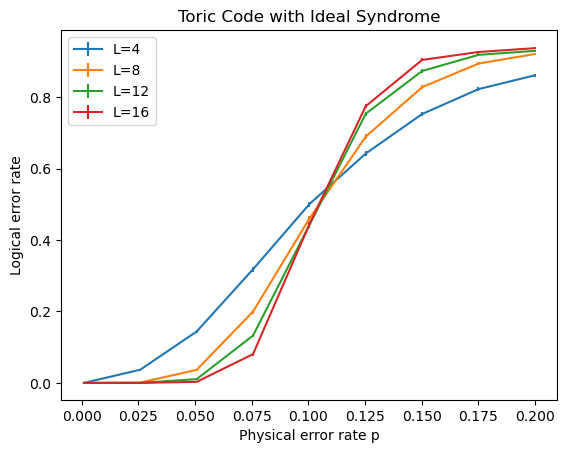

In [31]:
# Parameters
shots1 = 5000
Ls1 = range(4, 17, 4)
ps1 = np.linspace(0.001, 0.2, 9)
np.random.seed(42)
stage1_results = []

start1 = time.time()
for L in Ls1:
    print(f"  > L = {L}")
    Hx = toric_code_X_checks(L)
    Hz = toric_code_Z_checks(L)
    LX, LZ = toric_code_logicals(L)
    errs = [simulate_logical_errors(Hx, Hz, LX, LZ, p, shots1) / shots1 for p in ps1]
    stage1_results.append(np.array(errs))
print(f"Completed Stage 1 in {time.time() - start1:.2f} sec")

plt.figure()
for L, errs in zip(Ls1, stage1_results):
    stddev = np.sqrt(errs * (1 - errs) / shots1)
    plt.errorbar(ps1, errs, yerr=stddev, label=f"L={L}")
plt.xlabel("Physical error rate p")
plt.ylabel("Logical error rate")
plt.title("Toric Code with Ideal Syndrome")
plt.legend()
plt.show()

# Stage 2: Measurement Errors Included

This is a more realistic simulation in which the measurements of the syndrome can also contribute to errors. These errors physically correspond to an ancilla being prepared in the wrong state, or errors involving the CNOT gates or even the classical measurements being read off incorrectly (0 <-> 1). 

As the syndrome is faulty now, we need to measure the syndrome multiple number of times and there might be errors between said steps as well. So it is convenient to introduce a time-like dimension. Pymatching allows for decoding taking place over a 3D matching graph with this additional time dimension. This was introduced in arxiv.org/pdf/quant-ph/0110143.


In [26]:
def simulate_noisy_logical_errors(Hx, Hz, LX, LZ, p, q, shots, reps):
    
    # Initialize the PyMatching decoder for a 3D (space-time) problem.
    # 'repetitions' tells the decoder how many rounds of measurement there are.
    # 'timelike_weights' provides the cost for assuming a measurement error occurred,
    # based on the measurement error probability 'q'.
    decoder_X = Matching(Hx, weights=np.log((1 - p)/p), repetitions=reps,
                         timelike_weights=np.log((1 - q)/q), faults_matrix=LX)
    decoder_Z = Matching(Hz, weights=np.log((1 - p)/p), repetitions=reps,
                         timelike_weights=np.log((1 - q)/q), faults_matrix=LZ)

    # Get code parameters: N=number of qubits, Xs/Zs=number of stabilizers.
    N = Hx.shape[1]
    Xs, Zs = Hx.shape[0], Hz.shape[0]
    error_count = 0

    # This simulation runs one shot at a time 
    for _ in range(shots):
        # Z error decoding (affecting X-stabilizers) 

        # 1. Simulate physical Z errors for each qubit (N) at each time step (reps).
        zn = (np.random.rand(N, reps) < p).astype(np.uint8)
        # 2. Calculate the cumulative error over time. An error that occurs at time `t` persists.
        zcum = np.cumsum(zn, axis=1) % 2
        # 3. The final physical error is the state after all rounds. This determines the true logical state.
        final_z = zcum[:, -1]

        # 4. Calculate the "perfect" syndrome at each time step by multiplying the cumulative error
        #    by the check matrix.
        sx = (Hx @ zcum) % 2
        # 5. Simulate random measurement errors for each X-stabilizer at each time step.
        sx_err = (np.random.rand(Xs, reps) < q).astype(np.uint8)
        # 6. Assume the final measurement round is perfect (as described in arxiv.org/pdf/quant-ph/0110143)
        sx_err[:, -1] = 0
        # 7. Get the noisy syndrome by adding the perfect syndrome and the measurement errors.
        sx_noisy = (sx + sx_err) % 2
        
        # 8. The decoder needs to know WHEN a syndrome bit flips. This line calculates
        #    the difference between consecutive noisy measurements. A '1' here indicates a "detection event"
        #    in space-time, which is the input for the 3D matching algorithm.
        sx_noisy[:, 1:] = (sx_noisy[:, 1:] - sx_noisy[:, :-1]) % 2
        
        # 9. Decode the space-time detection events to predict the final logical state.
        pred_LX = decoder_X.decode(sx_noisy)
        # 10. Calculate the actual final logical state from the true final physical error.
        act_LX = final_z @ LX.T % 2

        # X error decoding (affecting Z-stabilizers) 
        # The process is identical to the above, but for X errors and Z stabilizers.
        xn = (np.random.rand(N, reps) < p).astype(np.uint8)
        xcum = np.cumsum(xn, axis=1) % 2
        final_x = xcum[:, -1]
        sz = (Hz @ xcum) % 2
        sz_err = (np.random.rand(Zs, reps) < q).astype(np.uint8)
        sz_err[:, -1] = 0
        sz_noisy = (sz + sz_err) % 2
        sz_noisy[:, 1:] = (sz_noisy[:, 1:] - sz_noisy[:, :-1]) % 2
        pred_LZ = decoder_Z.decode(sz_noisy)
        act_LZ = final_x @ LZ.T % 2

        # Check if the decoder's prediction for either X or Z was incorrect.
        if not (np.array_equal(pred_LX, act_LX) and np.array_equal(pred_LZ, act_LZ)):
            error_count += 1

    return error_count

# Plotting the results - II
This section runs the simulation for different code sizes (L) and physical error rates (p) and syndrome measutement error rate (q=p for this simultaion) then plots the results, showing how the logical error rate decreases as the code size increases.

  > L = 8
  > L = 10
  > L = 12
  > L = 14
Completed Stage 2 in 29.85 sec


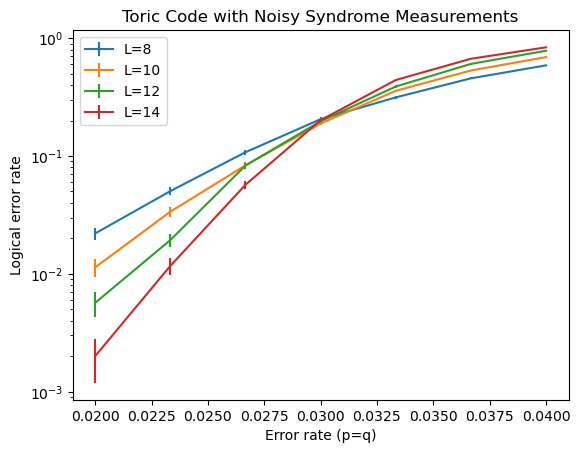

In [27]:
# Parameters
shots2 = 3000
Ls2 = range(8, 15, 2)
ps2 = np.linspace(0.02, 0.04, 7)
stage2_results = []

start2 = time.time()
for L in Ls2:
    print(f"  > L = {L}")
    Hx = toric_code_X_checks(L)
    Hz = toric_code_Z_checks(L)
    LX, LZ = toric_code_logicals(L)
    results = [simulate_noisy_logical_errors(Hx, Hz, LX, LZ, p, p, shots2, L) / shots2 for p in ps2]
    stage2_results.append(np.array(results))
print(f"Completed Stage 2 in {time.time() - start2:.2f} sec")

plt.figure()
for L, errs in zip(Ls2, stage2_results):
    stderr = np.sqrt(errs * (1 - errs) / shots2)
    plt.errorbar(ps2, errs, yerr=stderr, label=f"L={L}")
plt.yscale("log")
plt.xlabel("Error rate (p=q)")
plt.ylabel("Logical error rate")
plt.title("Toric Code with Noisy Syndrome Measurements")
plt.legend()
plt.show()